# Create Submission File

## Imports and get data

In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from HelpFunctions.date_and_time import most_recent_thursday, split_time

from DAX.HelpFunctions.get_dax_data import get_dax_data
from DAX.Models import baseline as dax_bl
from DAX.Models import garch11 as dax_garch

from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from Energy.Models import baseline as en_bl
from Energy.Models import Model4_population as en_m4_pop
from datetime import datetime
import pytz

# import importlib
# importlib.reload(Energy.Models)

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### DAX: Get and prepare Data
Use tuesday as last datapoint

In [23]:
# Insert Date of Wednesday (forecast-day) here. The current day has to be wednesday!!
start_date = datetime(2024, 2, 7, 14, 0, 0)
assert start_date.weekday() == 2

In [15]:
df_dax = get_dax_data()
# pretend_start_date = date(2023, 11, 22, 11, 00, 0, tzinfo=pytz.timezone('Europe/Berlin'))

df_dax = df_dax[df_dax.index.date <= start_date.date()]

In [11]:
df_dax.tail()

,Close,ret1,ret2,ret3,ret4,ret5
Date,,,,,,
2024-02-01 00:00:00+01:00,16859.039062,-0.264911,-0.669800,-0.489173,-0.605267,-0.283605
2024-02-02 00:00:00+01:00,16918.210938,0.350366,0.085454,-0.319434,-0.138807,-0.254901
2024-02-05 00:00:00+01:00,16904.060547,-0.083675,0.266691,0.001779,-0.403109,-0.222482
2024-02-06 00:00:00+01:00,17033.240234,0.761288,0.677613,1.027979,0.763067,0.358179
2024-02-07 00:00:00+01:00,16921.960938,-0.655450,0.105838,0.022163,0.372529,0.107617


### Energy: Get and prepare Data

In [5]:
from Energy.HelpFunctions.get_energy_data import fetch_energy_data
fetch_energy_data()

  0%|          | 0/268 [00:00<?, ?it/s]/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 268/268 [00:51<00:00,  5.22it/s]


In [7]:
df_en = get_energy_data(force_return=True)
df_en = prepare_data(df_en)
df_en.tail(100)

,gesamt
date_time,
2024-02-03 14:00:00,56.16325
2024-02-03 15:00:00,55.49975
2024-02-03 16:00:00,55.98875
2024-02-03 17:00:00,58.95075
2024-02-03 18:00:00,59.93425
...,...
2024-02-07 13:00:00,69.24350
2024-02-07 14:00:00,67.47475
2024-02-07 15:00:00,66.21075


In [24]:
df_en = df_en.loc[df_en.index <= start_date]

In [21]:
df_en = df_en[:-6]

<Axes: xlabel='date_time'>

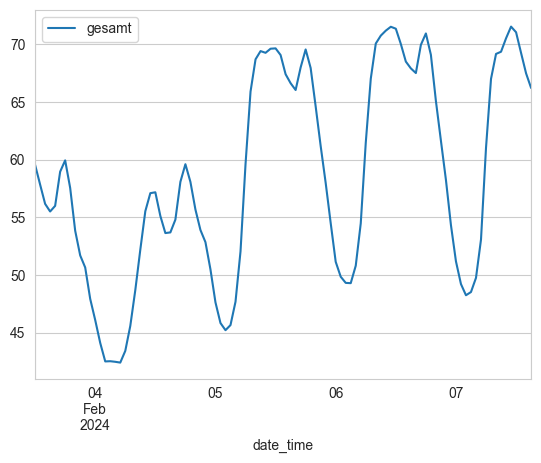

In [18]:
df_en.tail(100).plot()

In [19]:
# Check if still required next week ...
# df_en.loc['2024-01-17 16:00:00', 'gesamt'] = (df_en.loc['2024-01-17 15:00:00', 'gesamt'] +df_en.loc['2024-01-17 17:00:00', 'gesamt'])/2
# df_en.tail()

## Run models for the data

### DAX

In [20]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import baseline as bl

import importlib
importlib.reload(ag)
importlib.reload(bl)


# dax_bl.baseline(df_dax)
# forecast_dax = dax_garch.garch11(df_dax)
forecast_dax = mix_models([ag.garch11_norm_1y, bl.baseline_1y], [1,0.5], df_dax, 'DAX')
forecast_dax


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-08,DAX,1 day,-1.471075,-0.431829,0.015949,0.486681,1.450788
1,2024-02-09,DAX,2 day,-1.805224,-0.562150,0.020280,0.609579,1.846146
2,2024-02-12,DAX,5 day,-2.524377,-0.776079,0.037582,0.874236,2.480208
3,2024-02-13,DAX,6 day,-2.949666,-0.917584,0.057055,1.047316,2.979706
4,2024-02-14,DAX,7 day,-3.046416,-0.911790,0.065832,1.115923,3.058655


### Energy  

In [27]:
from Energy.Models import mstl
from Energy.Models.baseline import baseline
from HelpFunctions.mix_models import mix_models_per_horizon
from Energy.Models.Model4_sunhours import model4_sunhours
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_population import model4_population
from Energy.Models import Model5

# en_bl.baseline(df_en, LAST_IDX=-1, offset_horizons=11)

import importlib
importlib.reload(Model5)
importlib.reload(mstl)

weights_m5_bl_m4_x = [1,1]
functions_m5_bl_m4_x = [mstl.mstl, Model5.model5]




# forecast_en = en_m4_pop.model4_population(df_en, offset_horizons=15)
forecast_en = mix_models(functions_m5_bl_m4_x, weights_m5_bl_m4_x, df_en, target="energy", offset_horizons=9)
forecast_en

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-09 12:00:00,energy,36 hour,57.654474,64.081444,67.540082,69.973334,74.607695
1,2024-02-09 16:00:00,energy,40 hour,55.170165,60.874453,64.033996,66.601796,71.260723
2,2024-02-09 20:00:00,energy,44 hour,52.200738,57.218683,59.863792,62.327089,67.083828
3,2024-02-10 12:00:00,energy,60 hour,48.157139,54.566580,57.560163,59.792278,64.030168
4,2024-02-10 16:00:00,energy,64 hour,45.835233,51.521992,54.216481,56.583144,60.845600
5,2024-02-10 20:00:00,energy,68 hour,43.796733,48.797149,50.977203,53.239363,57.599630


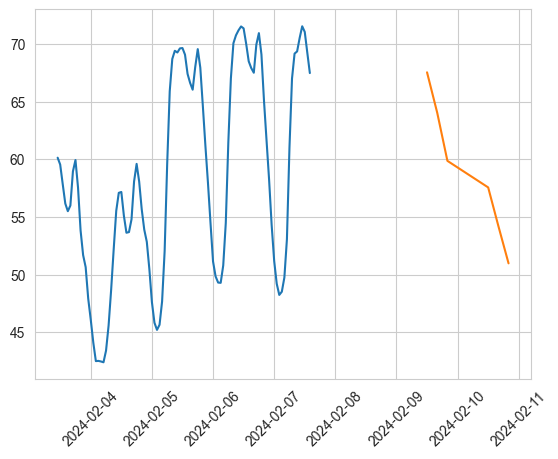

In [28]:
plot_df = forecast_en.copy() \
    .set_index('forecast_date')['q0.5']
plt.plot(df_en[-100:])
plt.plot(plot_df)
plt.xticks(rotation=45)
plt.show()

### Infections

In [29]:
forecast_infections = {
    'forecast_date': [start_date.strftime('%Y-%m-%d')] * 5,
    'target': ['infections'] * 5,
    'horizon': ['0 week', '1 week', '2 week', '3 week', '4 week'],
    # 'q0.025': ['NA'] * 5,
    # 'q0.25': ['NA'] * 5,
    # 'q0.5': ['NA'] * 5,
    # 'q0.75': ['NA'] * 5,
    # 'q0.975': ['NA'] * 5,
    'q0.025': [np.nan] * 5,
    'q0.25': [np.nan] * 5,
    'q0.5': [np.nan] * 5,
    'q0.75': [np.nan] * 5,
    'q0.975': [np.nan] * 5
}

forecast_infections = pd.DataFrame(forecast_infections)

In [30]:
forecast_infections

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-07,infections,0 week,NaN,NaN,NaN,NaN,NaN
1,2024-02-07,infections,1 week,NaN,NaN,NaN,NaN,NaN
2,2024-02-07,infections,2 week,NaN,NaN,NaN,NaN,NaN
3,2024-02-07,infections,3 week,NaN,NaN,NaN,NaN,NaN
4,2024-02-07,infections,4 week,NaN,NaN,NaN,NaN,NaN


## Merge results

Check results: Are they valid, forecast_date is right? The last entry might be cut off

In [31]:
forecasts = pd.concat([forecast_dax,forecast_en, forecast_infections]).reset_index().drop(columns=['index'])
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-08,DAX,1 day,-1.471075,-0.431829,0.015949,0.486681,1.450788
1,2024-02-09,DAX,2 day,-1.805224,-0.562150,0.020280,0.609579,1.846146
2,2024-02-12,DAX,5 day,-2.524377,-0.776079,0.037582,0.874236,2.480208
3,2024-02-13,DAX,6 day,-2.949666,-0.917584,0.057055,1.047316,2.979706
4,2024-02-14,DAX,7 day,-3.046416,-0.911790,0.065832,1.115923,3.058655
5,2024-02-09 12:00:00,energy,36 hour,57.654474,64.081444,67.540082,69.973334,74.607695
6,2024-02-09 16:00:00,energy,40 hour,55.170165,60.874453,64.033996,66.601796,71.260723
7,2024-02-09 20:00:00,energy,44 hour,52.200738,57.218683,59.863792,62.327089,67.083828
8,2024-02-10 12:00:00,energy,60 hour,48.157139,54.566580,57.560163,59.792278,64.030168
9,2024-02-10 16:00:00,energy,64 hour,45.835233,51.521992,54.216481,56.583144,60.845600


If everything seems good: Override forecast_date

In [32]:
forecasts['forecast_date'] = [start_date.strftime('%Y-%m-%d') for _ in range(len(forecasts))]

In [33]:
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-07,DAX,1 day,-1.471075,-0.431829,0.015949,0.486681,1.450788
1,2024-02-07,DAX,2 day,-1.805224,-0.562150,0.020280,0.609579,1.846146
2,2024-02-07,DAX,5 day,-2.524377,-0.776079,0.037582,0.874236,2.480208
3,2024-02-07,DAX,6 day,-2.949666,-0.917584,0.057055,1.047316,2.979706
4,2024-02-07,DAX,7 day,-3.046416,-0.911790,0.065832,1.115923,3.058655
5,2024-02-07,energy,36 hour,57.654474,64.081444,67.540082,69.973334,74.607695
6,2024-02-07,energy,40 hour,55.170165,60.874453,64.033996,66.601796,71.260723
7,2024-02-07,energy,44 hour,52.200738,57.218683,59.863792,62.327089,67.083828
8,2024-02-07,energy,60 hour,48.157139,54.566580,57.560163,59.792278,64.030168
9,2024-02-07,energy,64 hour,45.835233,51.521992,54.216481,56.583144,60.845600


### Check df & Save csv-File

In [34]:
from HelpFunctions.check_submission import check_submission_df

check_submission_df(forecasts)
forecasts.to_csv(f'./Abgaben/{start_date.strftime("%Y%m%d")}_JakePeralta.csv', na_rep='NA', index=False)

Start checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- infections -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check